# Exploratory Data Analysis

In this section, we will perform data profiling on the training dataset - `customer.csv`.
The objective of this section is to understand the data that will be used to train the model, making use of statistics and visualizations, in order to identify potential issues that need to be addressed in the data preprocessing section.

## Dataset Overview
<table>
<thead>
<tr>
<th>Column Name</th>

<th>Type of Attribute</th>
</tr>
</thead>
<tbody>
<tr>
<td>custid</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>sex</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>is_employed</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>income</td>
<td>Numerical Ratio</td>
</tr>
<tr>
<td>marital_status</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>health_ins</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>housing_type</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>num_vehicles</td>
<td>Numerical Ratio</td>
</tr>
<tr>
<td>age</td>
<td>Numerical Ratio</td>
</tr>
<tr>
<td>state_of_res</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>code_column</td>
<td>Numerical Ratio</td>
</tr>
<tr>
<td>gas_usage</td>
<td>Numerical Ratio</td>
</tr>
<tr>
<td>rooms</td>
<td>Categorical Nominal</td>
</tr>
<tr>
<td>recent_move_b</td>
<td>Categorical Nominal</td>
</tr>
</tbody>
</table>



In [97]:
import os

import numpy as np
from scipy.stats import chi2_contingency

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

import problexity as pbx
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [98]:
df = pd.read_csv('../data/customer.csv')
rows,features = df.shape
print(f"Our dataset consists of {rows} rows and {features} features")

Our dataset consists of 72458 rows and 15 features


In [99]:
t_sum = df.isnull().sum().sum()
percentual = round(t_sum/(len(df)*len(df.columns))*100, 2)
print(f'\nIn our dataset we have a total of {t_sum} missing values ({percentual}%)')
print(f'Total Duplicated rows {df.duplicated().sum()}')


In our dataset we have a total of 32260 missing values (2.97%)
Total Duplicated rows 0


## Feature accessment

Now let's take a look at the characteristics of our dataset's features, such as the data type, the number of unique values, distribution of the values, etc. These individual insights can help us to understand the dataset better and to identify potential problems. First, let's write some useful functions to help us with this task.

In [100]:
def plot_category_distribution(df, column, palette='icefire'):
    """
    Plots a horizontal bar chart showing the distribution of categories in a specified column.
    """

    column_data = df[column].fillna('Missing')
    counts = column_data.value_counts()
    percentages = counts / counts.sum() * 100

    colors = sns.color_palette(palette, n_colors=len(counts))

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.barh(
        counts.index.astype(str), 
        percentages, 
        color=colors, 
        height=0.8
    )

    for bar, count, percentage in zip(bars, counts, percentages):
        ax.text(
            bar.get_width() / 2, 
            bar.get_y() + bar.get_height() / 2,
            f'{percentage:.1f}%\n({count:,})',
            ha='center',
            va='center',
            color='white',
            fontsize=7,  
        )

    ax.set_xlabel('Percentage')
    ax.set_title(f'{column.capitalize()} Distribution')
    ax.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

def plot_numeric_distribution(df, column, bins=30):
    """
    Plots a histogram showing the distribution of values in a specified column.
    """

    column_data = df[column].dropna()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(column_data, bins=bins, color='skyblue', edgecolor='black',range=(column_data.min(), column_data.max()))

    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{column.capitalize()} Distribution')

    plt.tight_layout()
    plt.show()


def show_num_missing_values(df, column):
    """
    Prints the number of missing values in each column of a DataFrame.
    """
    num_missing = df[column].isnull().sum()
    perct_missing = round(df[column].isnull().sum()/len(df)*100,2)
    if(num_missing == 0):
        print("There are no missing values in this column.")
    else:
        print("Missing values in this column: ", num_missing, "(",perct_missing,"% )")
        
def plot_feature_vs_target(df, feature, feature_type='categorical', palette='viridis', ylimit=None, x_rotation=0):
    """
    Plots the relationship between a feature and the health_ins target variable.
    """
    target = 'health_ins'
    if feature_type == 'categorical':
        category_counts = (
            df.groupby([feature, target])
                .size()
                .reset_index(name='Count')
        )
        total_counts = (
            df.groupby(feature)
                .size()
                .reset_index(name='Total')
        )

        category_percentages = category_counts.merge(total_counts, on=feature)
        category_percentages['Percentage'] = (
            category_percentages['Count'] / category_percentages['Total'] * 100
        )

        fig, ax = plt.subplots(figsize=(8, 4))
        for target_value, color, label in zip([0, 1], sns.color_palette(palette, n_colors=2), ["False", "True"]):
            subset = category_percentages[category_percentages[target] == target_value]
            
            if df[feature].nunique() == 2: 
                x_ticks = [0, 1] 
            else:
                x_ticks = subset[feature].unique() 

            ax.bar(
                x_ticks, 
                subset['Percentage'],
                color=color,
                alpha=0.7,
                label=label
            )

        ax.set_title(f'{feature.capitalize()} vs {target.capitalize()}')
        ax.set_xlabel(feature)
        plt.xticks(ticks=x_ticks, rotation=x_rotation)
        ax.set_ylabel('Percentage')
        ax.legend(title=target, loc='upper right')
        title = "Percentage of Individuals with Health Insurance by " + feature.capitalize()
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df, x=target, y=feature, hue=target, palette=palette)
        plt.title(feature + ' distribution by Health Insurance Status')
        plt.xlabel('Health Insurance')
        plt.ylabel(feature)
        if ylimit:
            plt.ylim(ylimit)
        else:
            ylim_btm = df[feature].min() - 0.1 * df[feature].min()
            ylim_top = df[feature].max() + 0.1 * df[feature].max()
            plt.ylim(ylim_btm, ylim_top)
        plt.tight_layout()
        plt.show()
  

#### **custid**

In [101]:
if(df['custid'].is_unique):
    print("custid is a unique identifier")
else:
    print("custid is not a unique identifier")

show_num_missing_values(df, 'custid')


custid is a unique identifier
There are no missing values in this column.


The custid is a unique identifier for each customer, thus it should be removed from the dataset before training the model.

#### **health_insurance**

The health_insurance is a binary feature that indicates if the customer has health insurance or not. It's our **target variable**.

In [102]:
show_num_missing_values(df, 'health_ins')

There are no missing values in this column.


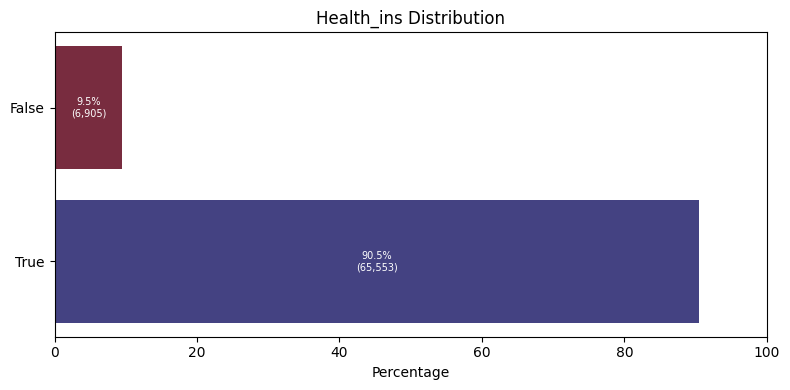

In [103]:
plot_category_distribution(df, 'health_ins', 'icefire')

Our target variable is **highly imbalanced**, with only 9.5% of the customers being uninsured. This is a big issue that will need to be addressed in the data preprocessing section, as training a model with an imbalanced target variable can lead to poor performance.

#### **sex**

In terms of gender, there are only two categories represented: Male/Female. The distribution of the values is balanced, with 51.7% of examples being Female and 48.3% being Male. There are no missing values. This is a categorical feature which seems to be well structured.


In [104]:
show_num_missing_values(df, 'sex')

There are no missing values in this column.


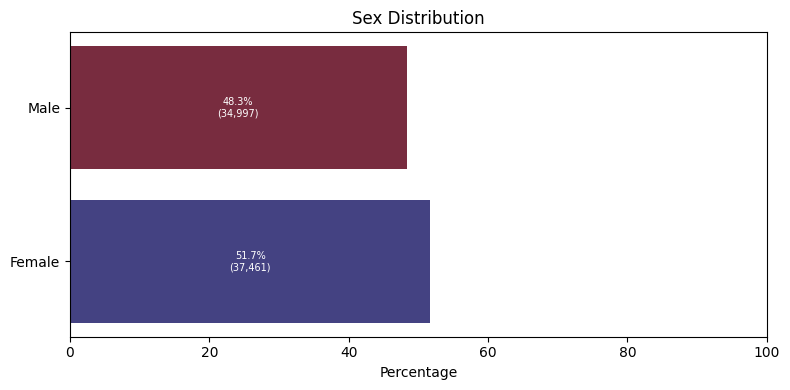

In [105]:
plot_category_distribution(df, 'sex', 'icefire')

#### **is_employed**


In [106]:
show_num_missing_values(df, 'is_employed')

Missing values in this column:  25515 ( 35.21 % )


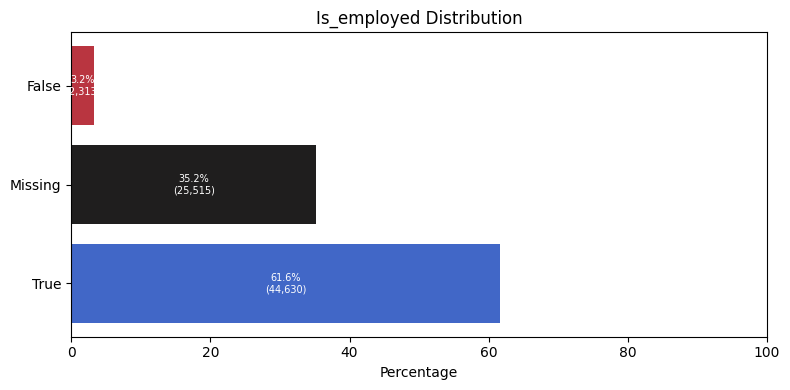

In [107]:
plot_category_distribution(df, 'is_employed', 'icefire')

This feature has a high percentage of missing values (35.2 %). It's highly imbalanced, among the non-missing values, 95% of the customers are employed. This feature will need to be addressed in the data preprocessing section.

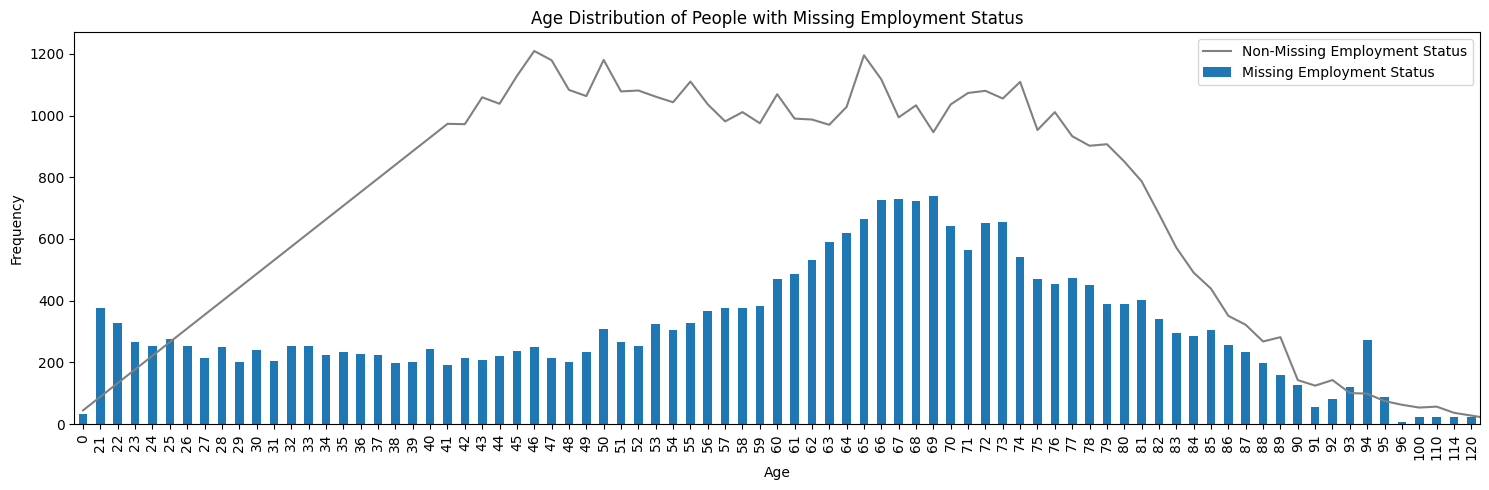

In [108]:
df_missing_employment_status = df[df['is_employed'].isnull()]
age_distribution_missing_employment = df_missing_employment_status['age'].value_counts().sort_index()

df_non_missing_employment_status = df[~df['is_employed'].isnull()]
age_distribution_non_missing = df_non_missing_employment_status['age'].value_counts().sort_index()

plt.figure(figsize=(15, 5))

age_distribution_missing_employment.plot(kind='bar',  label='Missing Employment Status')
age_distribution_non_missing.plot(kind='line', color='gray', label='Non-Missing Employment Status')

plt.title('Age Distribution of People with Missing Employment Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

As we can see in the image, younger individuals and elderly individuals(60+) are more likely to have missing employment status. In contraste middle-aged individuals(40-60) are more represented the group with non-missing employment status. This may be an indication that the missing values in the employment status are not missing at random, with students and retired individuals being more likely to have missing values.

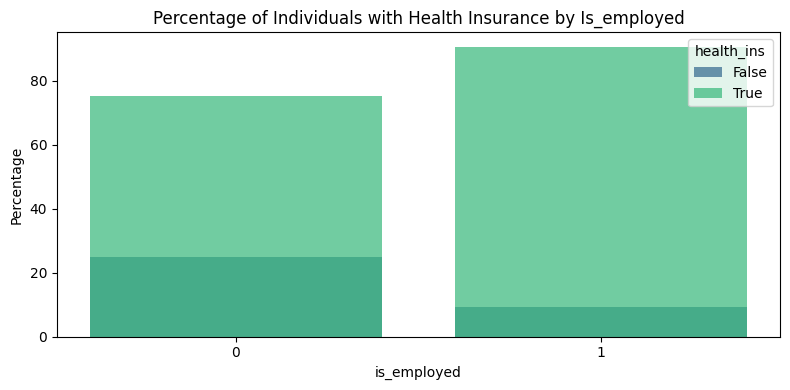

Of the employed people, 90.66% have health insurance.
Of the unemployed people, 75.23% have health insurance.


In [109]:
plot_feature_vs_target(df, 'is_employed', feature_type='categorical')

employed = df[df['is_employed'] == True]
employed_with_health_ins = employed[employed['health_ins'] == True]
percentage = round(len(employed_with_health_ins) / len(employed) * 100, 2)
print(f'Of the employed people, {percentage}% have health insurance.')


unemployed = df[df['is_employed'] == False]
unemployed_with_health_ins = unemployed[unemployed['health_ins'] == True]
percentage = round(len(unemployed_with_health_ins) / len(unemployed) * 100, 2)
print(f'Of the unemployed people, {percentage}% have health insurance.')


Unemployed individuals are more likely to be uninsured, while employed individuals are more likely to have health insurance. This is an expected result, as employed individuals are more likely to have access to health insurance through their employer.

#### **income**


There are no missing values in this column.


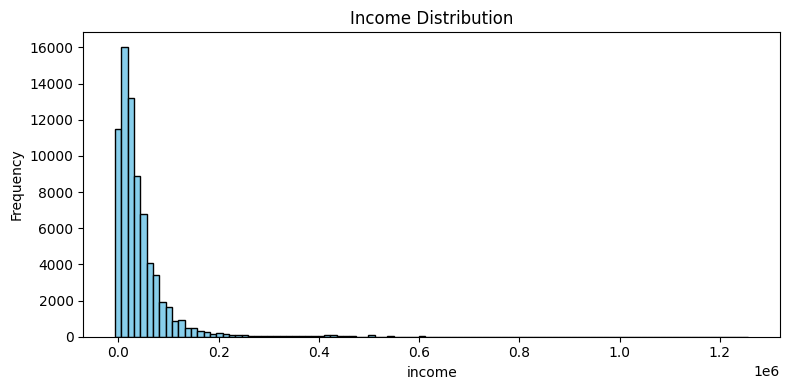

In [110]:
show_num_missing_values(df, 'income')

plot_numeric_distribution(df, 'income', 100)

In [111]:
df['income'].describe()

count    7.245800e+04
mean     4.188143e+04
std      5.827460e+04
min     -6.900000e+03
25%      1.070000e+04
50%      2.640000e+04
75%      5.200000e+04
max      1.257000e+06
Name: income, dtype: float64

In [112]:
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
IQR = Q3 - Q1

print(f'Interquartile Range for income: {IQR}')

Interquartile Range for income: 41300.0


**Income** is a numerical feature with values ranging from -6900 to 1257000. It has a mean of 41881 and a standard deviation of 58274. As we can see in the boxplot below, there's many outliers in the data. In the preprocessing section, we will use normalization to deal with these outliers. In particular, we will use the log transformation to normalize as our data is right-skewed.

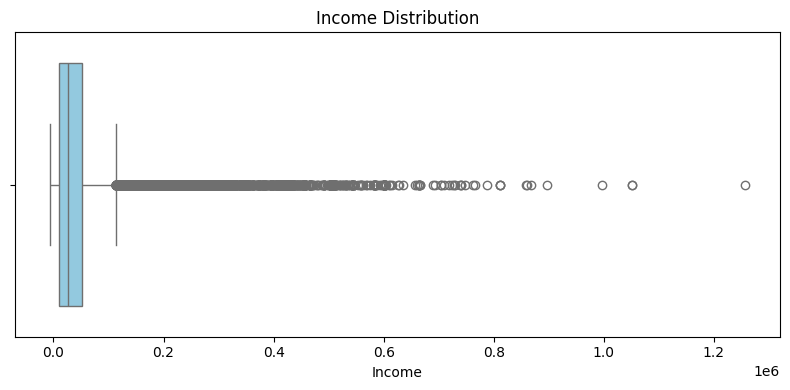

In [113]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='income', color='skyblue')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.tight_layout()
plt.show()


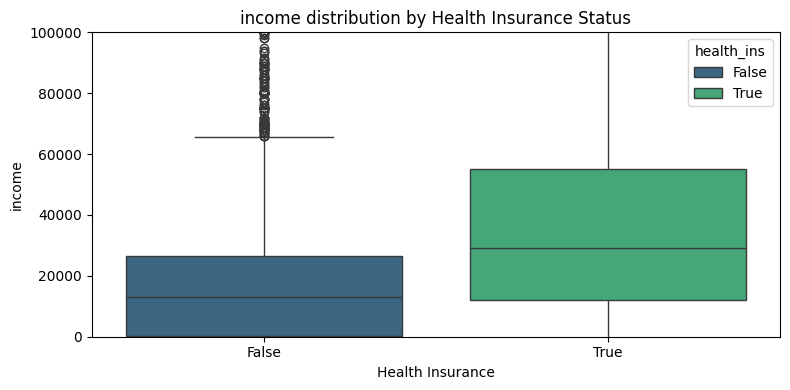

In [114]:
plot_feature_vs_target(df, 'income', feature_type='numerical', ylimit=(0, 100000), palette='viridis')


As we can see, there's some correlation between income distribution and health insurance status. Uninsured individuals tend to have lower income than insured individuals.

#### **marital_status**

There are no missing values in this column.


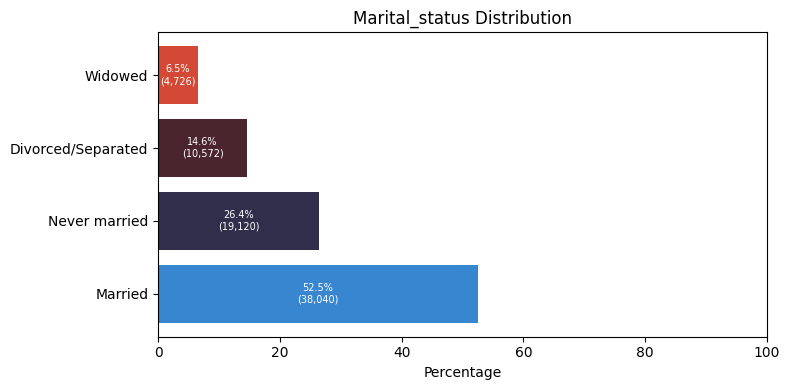

In [115]:
show_num_missing_values(df, 'marital_status')

plot_category_distribution(df, 'marital_status', 'icefire')

There's some imbalance in this category, 52.5% of the customers are married. There are no missing values.

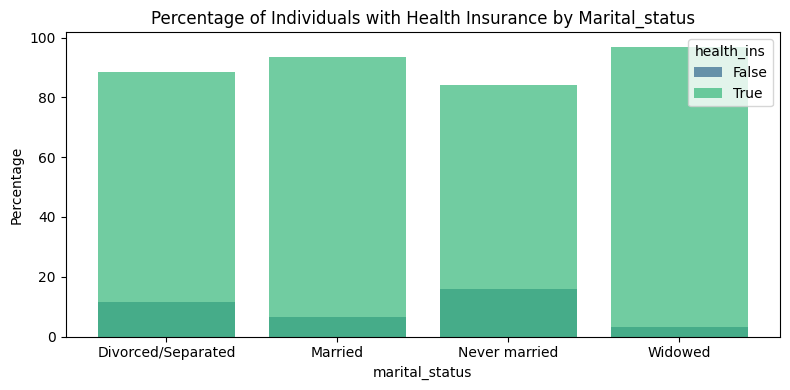

In [116]:
plot_feature_vs_target(df, 'marital_status', feature_type='categorical', palette='viridis')

As we can see, married and widowed individuals are more likely to have health insurance, while single and divorced individuals are more likely to be uninsured.

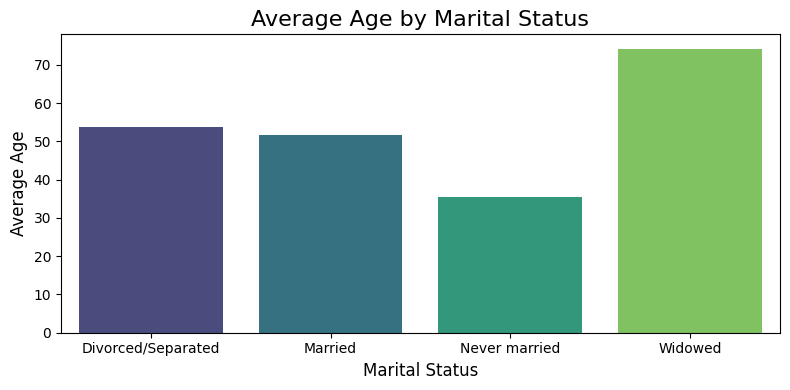

In [117]:
df_temp = df.copy()
marital_age = df_temp.groupby('marital_status')['age'].mean()

plt.figure(figsize=(8, 4))
sns.barplot(x=marital_age.index, y=marital_age.values, hue=marital_age.index, palette='viridis', legend=False)
plt.title('Average Age by Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Average Age', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As expected widowed individuals are more likely to be older, while single individuals are more likely to be younger.

#### **housing_type**

Missing values in this column:  1686 ( 2.33 % )


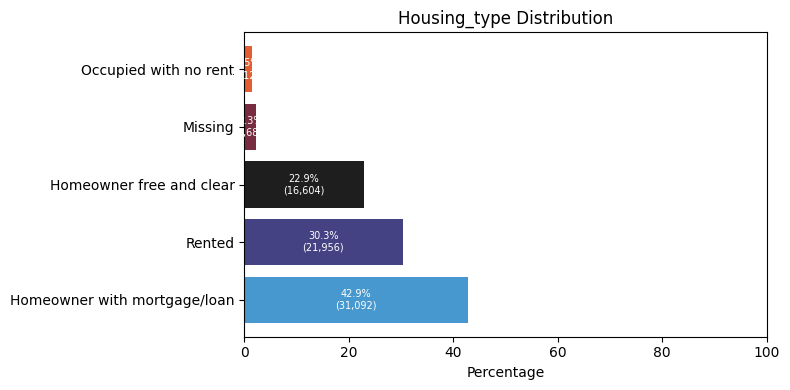

In [118]:
show_num_missing_values(df, 'housing_type')

plot_category_distribution(df, 'housing_type', 'icefire')

There's some missing values(2.33%) and the distribution of the values has some imbalance, with 42.9% of the customers being homeowners with mortgage. 

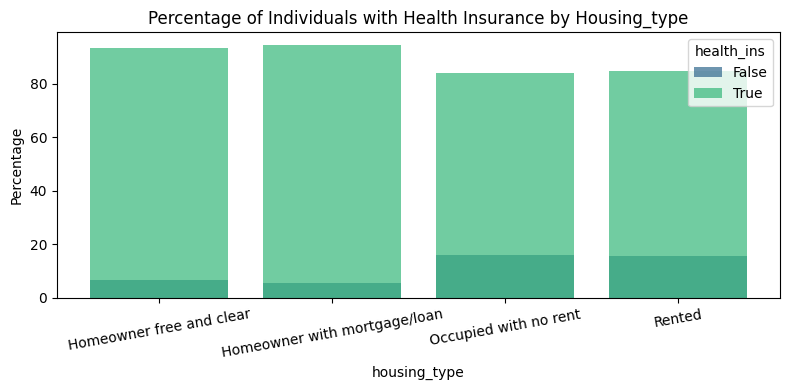

In [119]:
plot_feature_vs_target(df, 'housing_type', feature_type='categorical', palette='viridis', x_rotation=10)

Homeowners are more likely to have health insurance than renters. This is an expected result, as homeowners are more likely to be older and have higher income than renters

#### **num_vehicles**

Missing values in this column:  1686 ( 2.33 % )


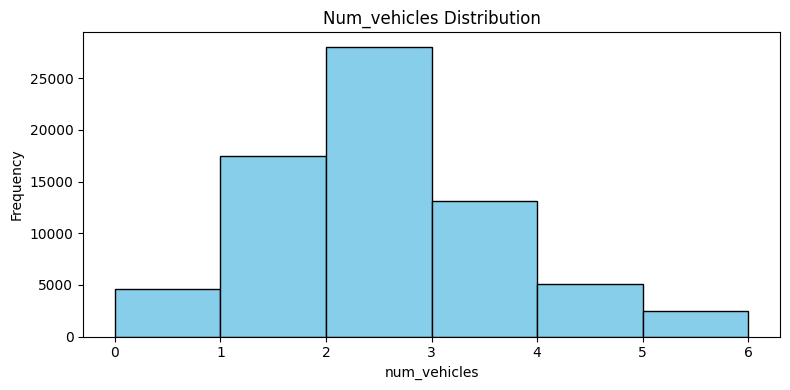

In [120]:
show_num_missing_values(df, 'num_vehicles')

plot_numeric_distribution(df, 'num_vehicles', 6)

There's some missing values(2.33%) in this feature, to deal with this we'll use KNN imputer. The distribution of the values follows a normal distribution with the most common value being 2 vehicles.

#### **age**

There are no missing values in this column.


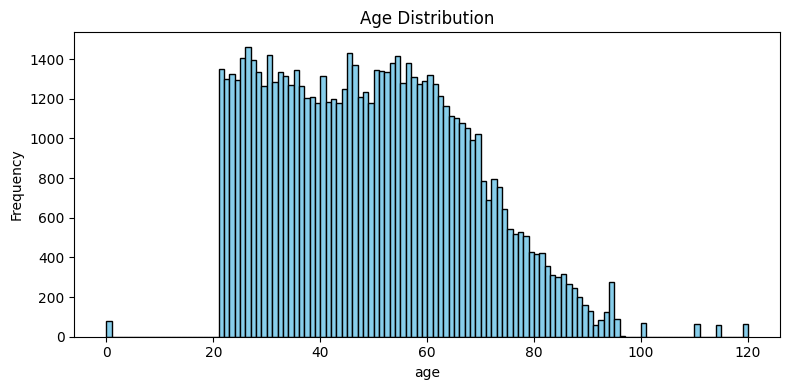

In [121]:
show_num_missing_values(df, 'age')

plot_numeric_distribution(df, 'age', 120)

In [122]:
df['age'].describe()

count    72458.000000
mean        49.208893
std         18.090035
min          0.000000
25%         34.000000
50%         48.000000
75%         62.000000
max        120.000000
Name: age, dtype: float64

As we can see, there are individuals with age 0 and some individuals with 110+ years old. The mean age is 49.2 years and the distribution is right-skewed. The minimum age is 0 and the maximum age is 120, in order to deal with outliers we will need to use min-max scaling.

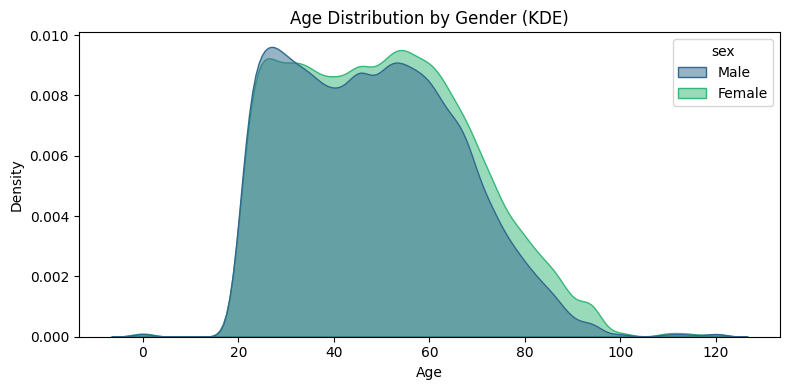

In [123]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df, x='age', hue='sex', palette='viridis', fill=True, alpha=0.5)
plt.title('Age Distribution by Gender (KDE)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


The gender is well distributed among the different age groups. With Male being the majority in younger age groups with Women being the majority in older age groups(40+).

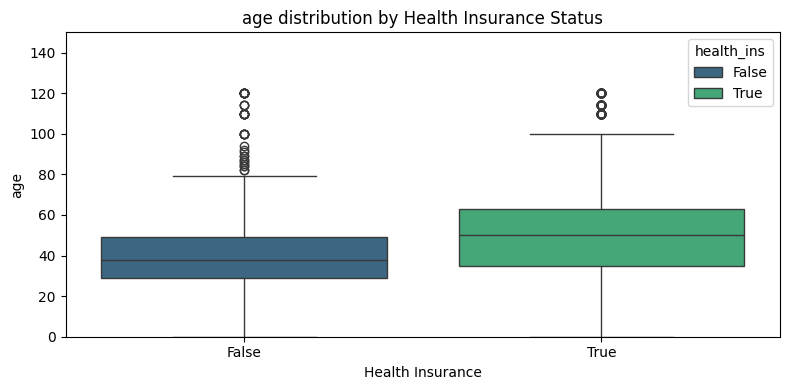

In [124]:
plot_feature_vs_target(df, 'age', feature_type='numerical', palette='viridis', ylimit=(0, 150), x_rotation=0)

Those with health insurance tend to be older than those without health insurance.

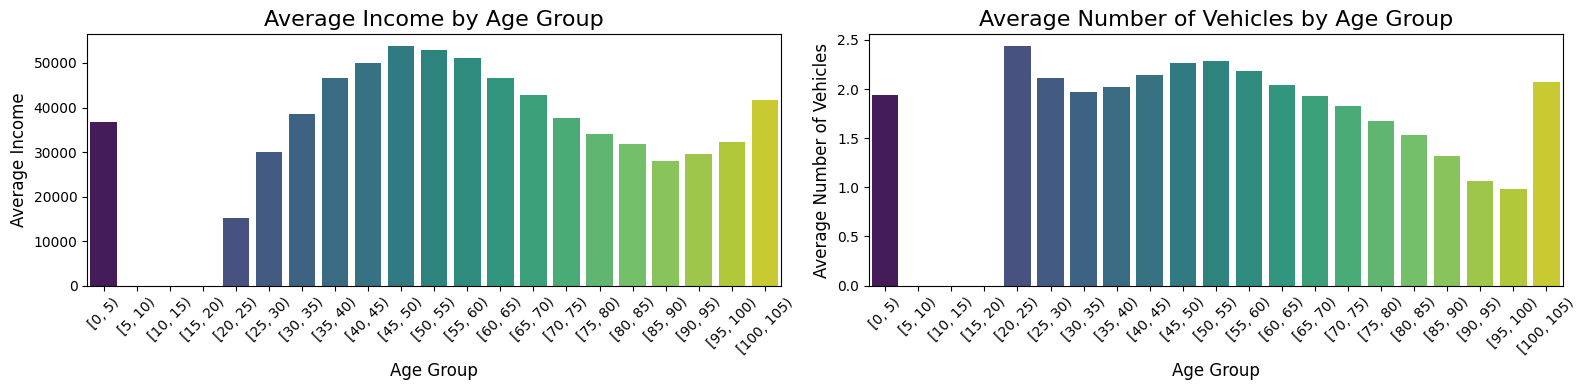

In [125]:
df_temp = df.copy()
df_temp['age_group'] = pd.cut(df_temp['age'], bins=range(0, 110, 5), right=False)

age_income = df_temp.groupby('age_group', observed=False)['income'].mean()
age_group_vehicles = df_temp.groupby('age_group', observed=False)['num_vehicles'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sns.barplot(ax=axes[0], x=age_income.index, y=age_income.values, hue=age_income.index, palette='viridis', dodge=False)
axes[0].set_title('Average Income by Age Group', fontsize=16)
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Average Income', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()

sns.barplot(ax=axes[1], x=age_group_vehicles.index, y=age_group_vehicles.values, hue=age_group_vehicles.index, palette='viridis', dodge=False)
axes[1].set_title('Average Number of Vehicles by Age Group', fontsize=16)
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('Average Number of Vehicles', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().remove()

plt.tight_layout()
plt.show()

The average income evolves as we we would expect, except for the increase in the values in the [0, 5] and 90+ age groups. The spike in the average number of vehicles in the  0 and the 100+ age group is also unexpected. These seem to be outliers.

In [126]:
print(f"Rows with age > 90 and employed: {df[(df['age'] > 90) & df['is_employed']].shape[0]}")
print(f"Rows with age = 0 and employed: {df[(df['age'] == 0) & df['is_employed']].shape[0]}")


Rows with age > 90 and employed: 167
Rows with age = 0 and employed: 43


The fact that there are 43 individuals with age 0 and 167 with age 90+ working corroborate that there are some inconsistencies. To correct these, we'll put the age of this individuals as missing values and use KNN imputer to fill them.

#### **state_of_res** and **code_column**

In [127]:
show_num_missing_values(df, 'state_of_res')
show_num_missing_values(df, 'code_column')

There are no missing values in this column.
There are no missing values in this column.


In [128]:
labelencoder = LabelEncoder()

df_test = df.copy()
df_test['state_of_res_encoded'] = labelencoder.fit_transform(df_test['state_of_res'])
df_test['code_column_encoded'] = labelencoder.fit_transform(df_test['code_column'])


contingency_table = pd.crosstab(df_test['state_of_res_encoded'], df_test['code_column_encoded'])

chi2, p, dof, ex = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V correlation between 'state_of_res' and 'code_column': {cramers_v}")

Cramér's V correlation between 'state_of_res' and 'code_column': 1.0


The state_of_res and code_column are categorical features that represent the state of residence of the customer. They have a correlation of 1, so we can drop one of them. We will drop the code_column feature.

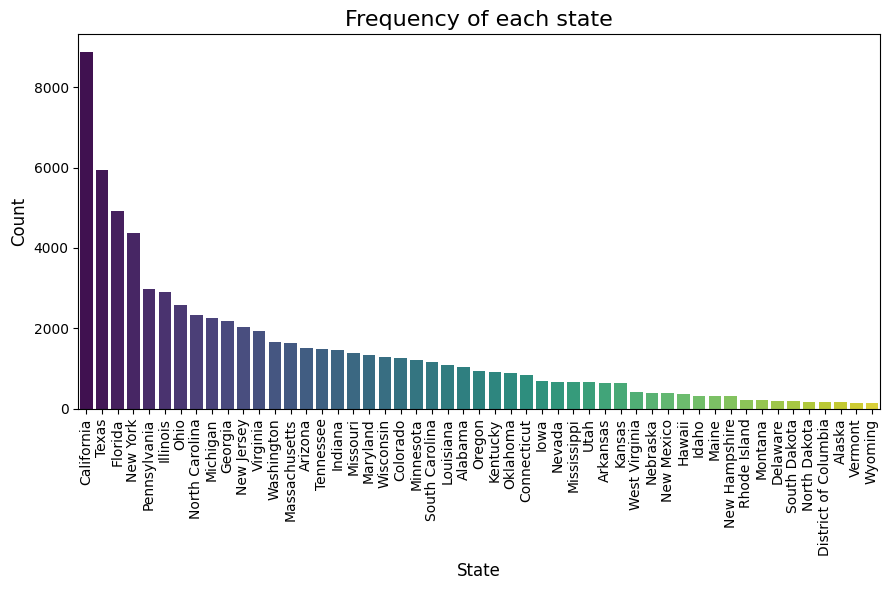

In [129]:
state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(9, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis', hue=state_counts.index, legend=False)
plt.title('Frequency of each state', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

There is no missing values in these features. The dataset has more rows from states with higher population, such as California and Texas as opposed to states with lower population, such as Wyoming and Vermont.

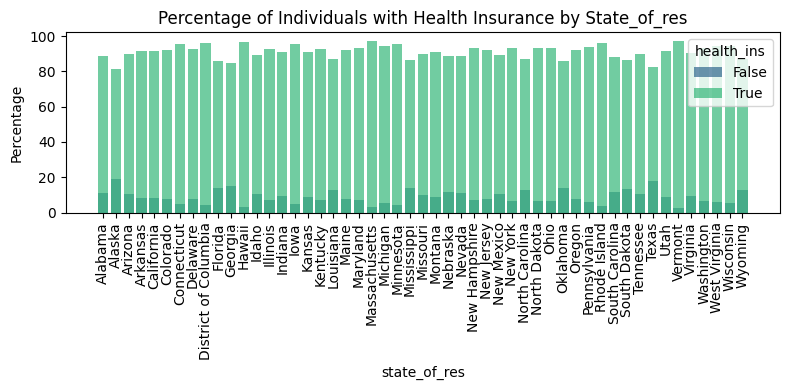

In [130]:
plot_feature_vs_target(df, 'state_of_res', feature_type='categorical', palette='viridis', x_rotation=90)

In [131]:
category_counts = (
    df.groupby(['state_of_res', 'health_ins'])
    .size()
    .reset_index(name='Count')
)

total_counts = (
    df.groupby('state_of_res')
    .size()
    .reset_index(name='Total')
)

category_percentages = category_counts.merge(total_counts, on='state_of_res')

category_percentages['Percentage'] = (
    category_percentages['Count'] / category_percentages['Total'] * 100
)

false_health_ins_percentage = category_percentages[category_percentages['health_ins'] == 0]

false_health_ins_percentage = false_health_ins_percentage.sort_values(
    by='Percentage', ascending=False
)

print('States with the highest percentage of individuals without health insurance:')
print(false_health_ins_percentage.head(5))

print('\nStates with the lowest percentage of individuals without health insurance:')
print(false_health_ins_percentage.tail(5))


States with the highest percentage of individuals without health insurance:
   state_of_res  health_ins  Count  Total  Percentage
2        Alaska       False     30    160   18.750000
86        Texas       False   1056   5938   17.783766
20      Georgia       False    331   2177   15.204410
72     Oklahoma       False    125    889   14.060742
18      Florida       False    687   4921   13.960577

States with the lowest percentage of individuals without health insurance:
            state_of_res  health_ins  Count  Total  Percentage
16  District of Columbia       False      7    168    4.166667
78          Rhode Island       False      8    218    3.669725
22                Hawaii       False     12    354    3.389831
42         Massachusetts       False     49   1635    2.996942
90               Vermont       False      4    146    2.739726


The states with more individuals without health insurance are Alaska, Texas, and Georgia. The states with more individuals with health insurance are District of Columbia, Rhode Island, and Hawaii.

#### **gas_usage**

Missing values in this column:  1686 ( 2.33 % )


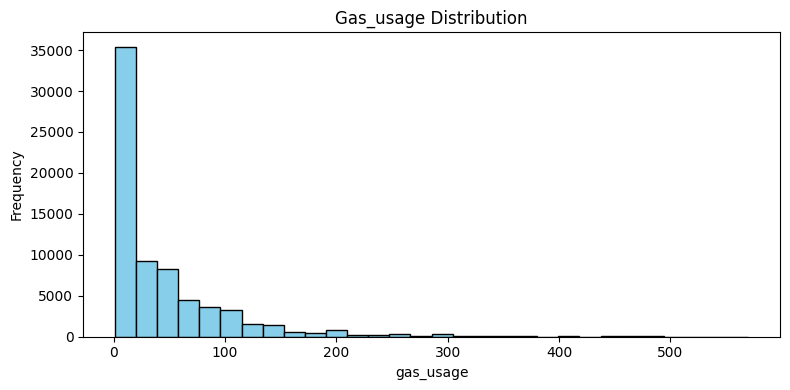

In [132]:
show_num_missing_values(df, 'gas_usage')

plot_numeric_distribution(df, 'gas_usage', 30)

In [133]:
df['gas_usage'].describe()

count    70772.000000
mean        41.230501
std         63.149323
min          1.000000
25%          3.000000
50%         10.000000
75%         60.000000
max        570.000000
Name: gas_usage, dtype: float64

There's some missing values in this feature(2.33%), to fill them we'll use KNN imputer. The distribution of the values is right-skewed, with a mean of 41 and a standard deviation of 63. We will use log normalization to deal with the outliers. 

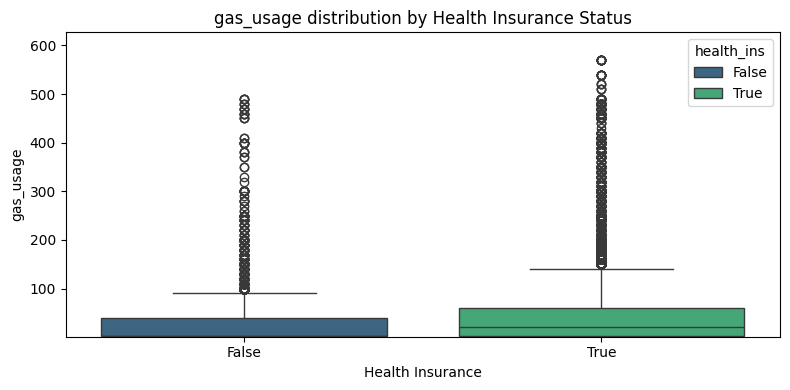

In [134]:
plot_feature_vs_target(df, 'gas_usage', feature_type='numerical', palette='viridis')

Those with health insurance tend to have higher gas usage than those without health insurance.

#### **rooms**

In [135]:
df['rooms'].value_counts()


rooms
2    12230
3    12134
5    12098
1    12042
6    11999
4    11955
Name: count, dtype: int64

There are no missing values in this column.


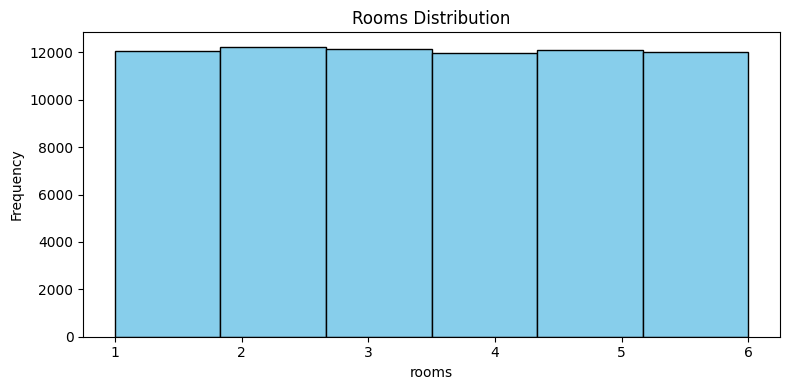

In [136]:
show_num_missing_values(df, 'rooms')

plot_numeric_distribution(df, 'rooms', 6)

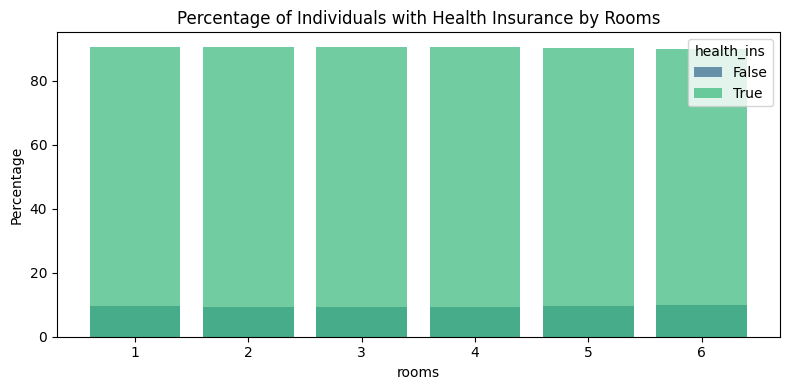

In [137]:
plot_feature_vs_target(df, 'rooms', palette='viridis')

In [138]:
contingency_table = pd.crosstab(df['rooms'], df['health_ins'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V correlation between 'rooms' and 'health_ins': {cramers_v}")

Cramér's V correlation between 'rooms' and 'health_ins': 0.008352802294724517


It doesn't seem to have a strong correlation between the rooms feature and the target variable. Thus, we will drop this feature.

#### **recent_move_b**

Missing values in this column:  1687 ( 2.33 % )


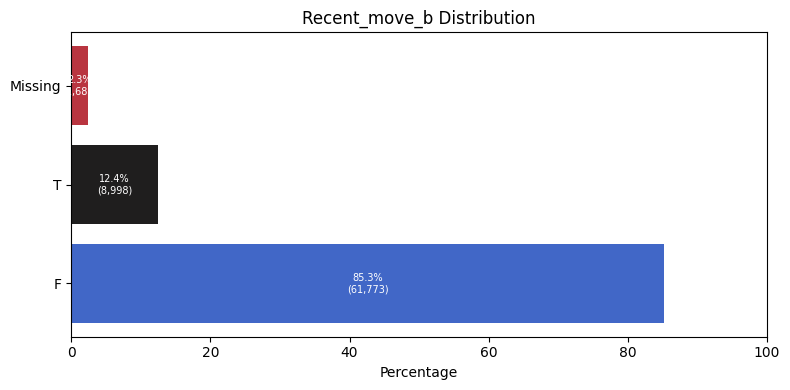

In [139]:
show_num_missing_values(df, 'recent_move_b')

plot_category_distribution(df, 'recent_move_b', 'icefire')

The recent_move_b has some missing values(2.33%), to fill them we'll use KNN imputer. The distribution of the values is imbalance, with 85.3% of the customers not having moved recently.

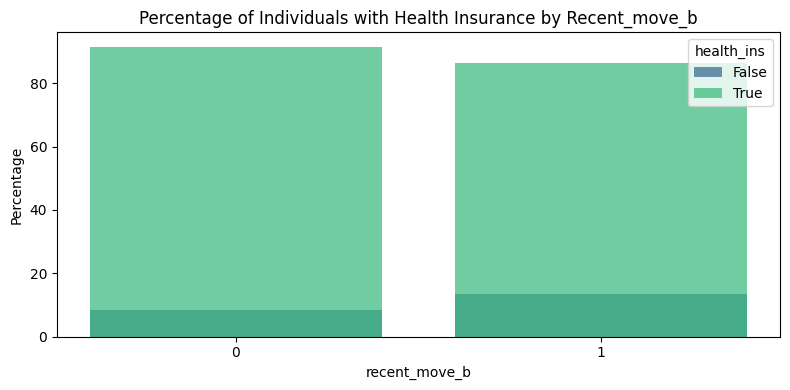

In [140]:
plot_feature_vs_target(df, 'recent_move_b', palette='viridis')

There's a slight correlation between recent move and health insurance status. Those who have moved recently are more likely to be uninsured than those who have not moved recently.

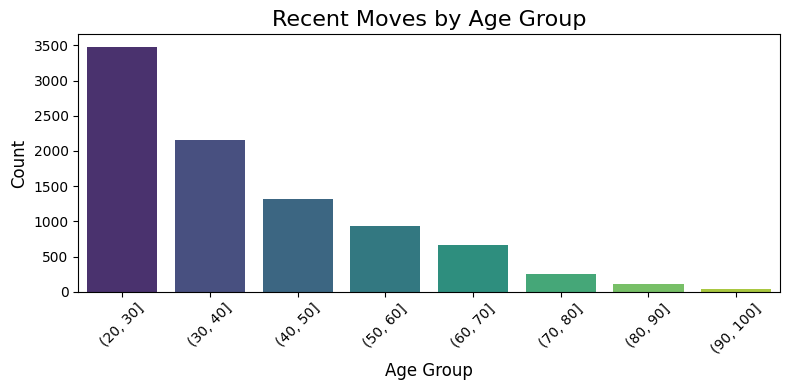

In [141]:
df_temp = df[df['recent_move_b'] == 'T'].copy()
df_temp['age_group'] = pd.cut(df_temp['age'], bins=range(20, 110, 10))

age_recent_moves = df_temp.groupby('age_group', observed=False).size()

plt.figure(figsize=(8, 4))
sns.barplot(x=age_recent_moves.index, y=age_recent_moves.values, hue=age_recent_moves.index, palette='viridis', dodge=False)
plt.legend().remove()

plt.title('Recent Moves by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

As we can see, the ones more prone to move are the younger individuals, while the older individuals are less likely to move.

/tmp/ipykernel_377620/2301172441.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


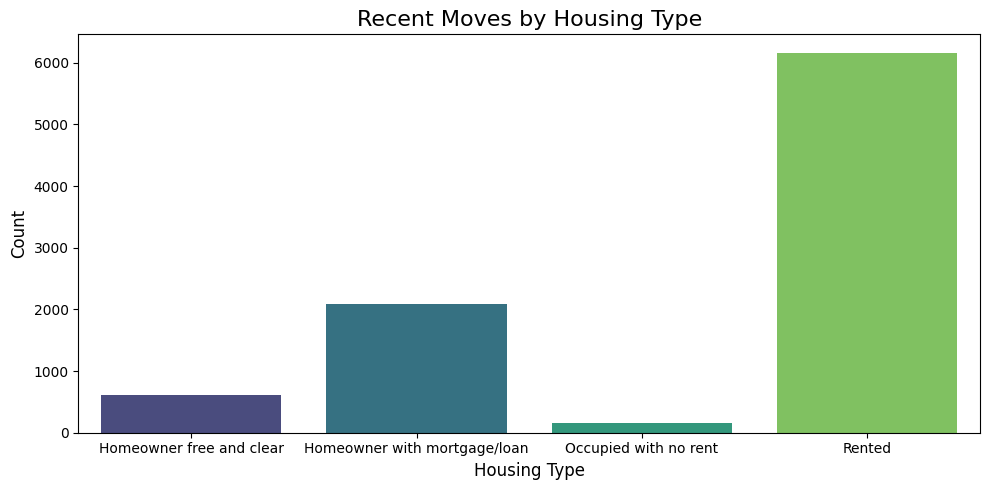

In [142]:

df_temp = df[df['recent_move_b'] == 'T'].copy()
df_temp = df_temp.groupby(['housing_type']).size()

plt.figure(figsize=(10, 5))
sns.barplot(x=df_temp.index, y=df_temp.values, hue=df_temp.index, palette='viridis', dodge=False)
plt.legend().remove()

plt.title('Recent Moves by Housing Type', fontsize=16)
plt.xlabel('Housing Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Those who move tend to moveto rented houses. This is an expected result, as renters are more likely to move than homeowners.

## Correlations


In [143]:
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']
categorical_features = ['health_ins', 'sex', 'is_employed', 'marital_status', 'housing_type', 'state_of_res', 'code_column', 'recent_move_b']

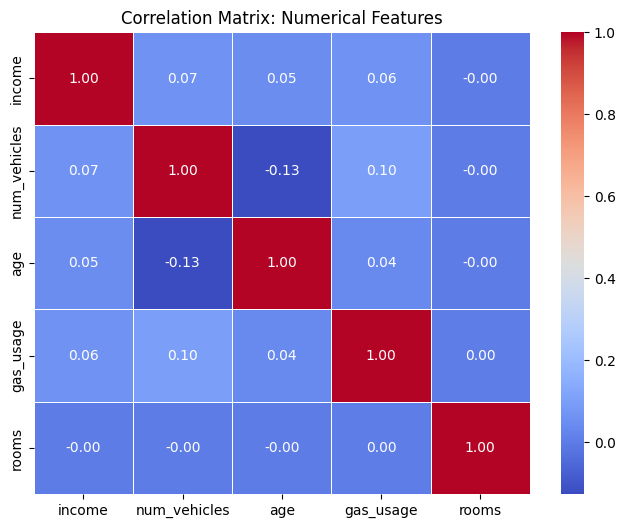

In [144]:
numerical_df = df[numerical_features]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Numerical Features")
plt.show()

Between numerical features it doesn't seem to have a strong correlation.

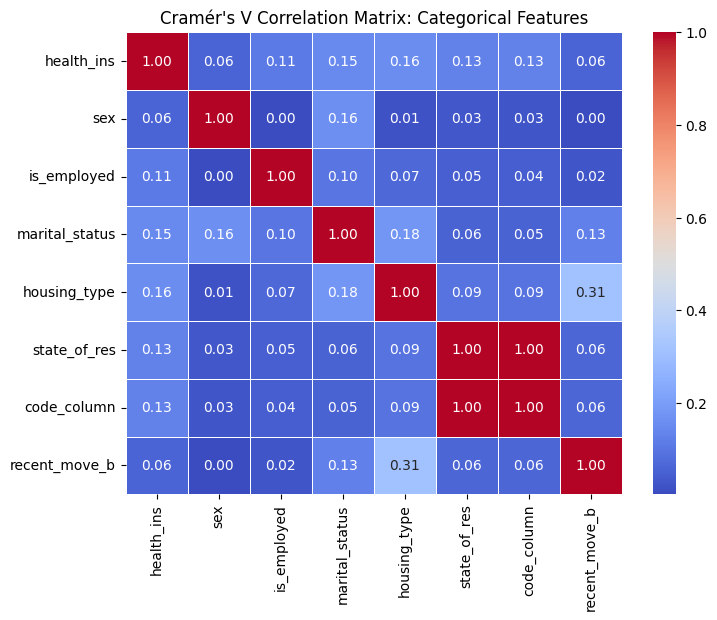

In [145]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1  
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Cramér's V Correlation Matrix: Categorical Features")
plt.show()

Other than the correlation we already mentioned between state_of_res and code_column, there's no strong correlation between the other features. There's a slight correlation between marital_status and housing_type, and between housing_type and recent_move_b.

# Data Preprocessing

After having identified some issues of the training dataset in the EDA phase, we will now proceed to preprocess the data.

Once the data cleaning process must be applied to both training and test datasets, we will create a function to ensure that we are applying the same transformations to both datasets.

The function must perform the following tasks:
- Remove unnecessary columns
- Deal with outliers
- Scale numerical features (considering Standard Scaling and Min-Max Scaling)
- Encode categorical features (considering Label Encoding and One-Hot Encoding)
- Treat missing values

In [146]:
def preprocess(data, isTest = False):
    # is_employed null values are filled with False
    # data['is_employed'] = data['is_employed'].fillna(False)

    # drop columns 
    cols_to_drop = ['Unnamed: 0','custid','code_column']
    if isTest:
        cols_to_drop.append('health_ins')
    data = data.drop(cols_to_drop, axis=1)

    # put ages < 21 and > 99 to Nan
    data['age'] = data['age'].apply(lambda x: x if 21 <= x <= 99 else None)
    
    # min max scaling for age [0-10]
    min_max_columns = ['age']
    minmax_scaler = MinMaxScaler()
    data[min_max_columns] = minmax_scaler.fit_transform(data[min_max_columns]).round(4)*10
    
    # log normalization
    log_columns = ['income', 'gas_usage']
    data[log_columns] = data[log_columns].apply(lambda x: np.log1p(x - x.min() + 1)).round(4)
    
    # label encoding
    cols_label_encode = ['sex','is_employed','state_of_res']
    if not isTest:
        cols_label_encode.append('health_ins')
    label_encoder = LabelEncoder()
    for col in cols_label_encode:
        data[col] = label_encoder.fit_transform(data[col])

    # one hot encoding
    cols_one_hot_encode = ['marital_status', 'housing_type', 'is_employed']
    data = pd.get_dummies(data, columns=cols_one_hot_encode, dummy_na=False)
    dummies = list(filter(lambda x: x.startswith(tuple(cols_one_hot_encode)), data.columns))
    for col in dummies:
        data[col] = label_encoder.fit_transform(data[col])
    
    # scale the state_of_res column
    data['state_of_res'] = MinMaxScaler().fit_transform(data[['state_of_res']])

    # encode recent_move_b with label encoder but let the nan values as they are
    data['recent_move_b'] = label_encoder.fit_transform(data['recent_move_b'])
    data['recent_move_b'] = data['recent_move_b'].replace(2, None)

    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_imputed = knn_imputer.fit_transform(data)
    df_imputed = pd.DataFrame(df_imputed, columns=data.columns)
    return df_imputed

Now we can apply the preprocessing steps to the training dataset.

In [147]:
df = preprocess(df)
df.head(10)

,sex,income,health_ins,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_0,is_employed_1,is_employed_2
0,1.0,10.2717,1.0,0.0,0.400,0.0,5.3519,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,10.3123,1.0,0.0,8.133,0.0,1.3863,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,10.2365,1.0,2.0,1.333,0.0,3.7136,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,10.7071,1.0,1.0,9.600,0.0,4.7958,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,10.7343,1.0,2.0,6.133,0.0,1.3863,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,1.0,9.7982,1.0,2.0,7.333,0.0,5.3033,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,10.3952,0.0,2.0,0.667,0.0,1.3863,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,0.0,10.6335,1.0,2.0,6.933,0.0,3.9318,5.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,10.3704,1.0,5.0,0.800,0.0,1.3863,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,10.5480,1.0,3.0,4.400,0.0,3.0445,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [148]:
# Columns after preprocessing
df.columns.to_list()

['sex',
 'income',
 'health_ins',
 'num_vehicles',
 'age',
 'state_of_res',
 'gas_usage',
 'rooms',
 'recent_move_b',
 'marital_status_Divorced/Separated',
 'marital_status_Married',
 'marital_status_Never married',
 'marital_status_Widowed',
 'housing_type_Homeowner free and clear',
 'housing_type_Homeowner with mortgage/loan',
 'housing_type_Occupied with no rent',
 'housing_type_Rented',
 'is_employed_0',
 'is_employed_1',
 'is_employed_2']

In [149]:
# No missing values
df.isnull().sum().sum()

np.int64(0)

# Model experimentation

In this section, we will experiment, for the first time, some classification models on the preprocessed dataset. 

In order to have a simple baseline, we will employ simple classification algorithms that are easy to interpret and understand. We will use the following models:
- Decision Tree
- Random Forest
- K-Nearest Neighbors

The objective of this section is to get a sense of how the models perform on the dataset to identify potential candidates for further optimization, or find a problem with the data that needs to be addressed before proceeding to more complex models.

We will also perform some hyperparameter tuning on the models to see how their performance can be improved with some optimization. The following parameters will be tuned:
- Decision Tree: `max_depth`
- Random Forest: `n_estimators`
- K-Nearest Neighbors: `n_neighbors`

In order to get some performance metrics, we will divide the training data into a training and validation sets (70% - 30%), and use the valdation set to evaluate the models.

In [150]:
# Split the data into train and test
X = df.drop('health_ins', axis=1)
y = df['health_ins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Each model will be evaluated using the following metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- Specificity
- Confusion Matrix

For different hyperparameters, we will store the results in a DataFrame to compare the performance of the models. Then, for the best model of each type, we will store its metrics in another Dataframe to later compare the different algorithms.

In [151]:
# Function to, given the prediction of a model, return its performance metrics
def get_metrics(y_pred):
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn+fp),3)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'specificity': spec, 'cm': cm}

In [152]:
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

For a better visualization of hyperparameters impact on the performance of these models, we will plot the performance metrics for different values of the hyperparameters using the following function:

In [153]:
def plot_measures(measures):
    parameters = measures.iloc[:,0]
    accuracy = measures.iloc[:,1]
    precision = measures.iloc[:,2]
    recall = measures.iloc[:,3]
    f1 = measures.iloc[:,4]
    spec = measures.iloc[:,5]

    sns.lineplot(x=parameters, y=accuracy, label='accuracy')
    sns.lineplot(x=parameters, y=precision, label='precision')
    sns.lineplot(x=parameters, y=recall, label='recall')
    sns.lineplot(x=parameters, y=f1, label='f1')
    sns.lineplot(x=parameters, y=spec, label='specificity')

## Decision Tree

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with None
None generates the following depth: 33


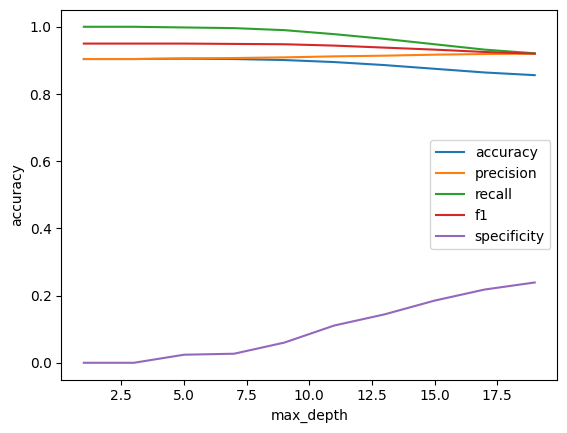

In [154]:
dt_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 20, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dt_measures.loc[len(dt_measures)] = new_row

    if max_depth == None:
        print(f'None generates the following depth: {model.get_depth()}')


plot_measures(dt_measures)

In [155]:
# Choose decision tree with max_depth = 9
row = dt_measures[dt_measures['max_depth'] == 9]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.909,0.99,0.948,0.06,"[[125, 1951], [194, 19468]]"


## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


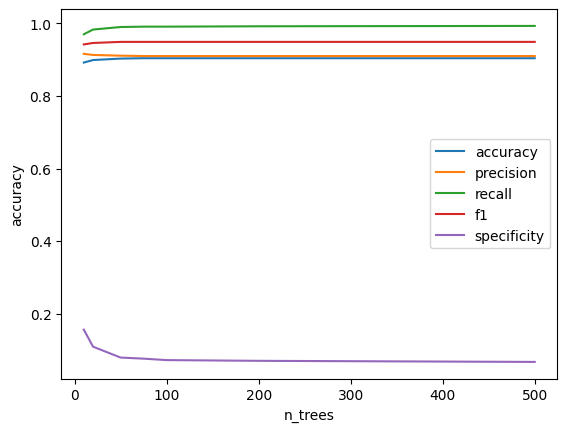

In [156]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [157]:
# Choose random forest with n_trees = 100
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.909,0.990,0.948,0.060,"[[125, 1951], [194, 19468]]"
1,Random Forest,0.904,0.910,0.991,0.949,0.072,"[[150, 1926], [171, 19491]]"


## K-Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23


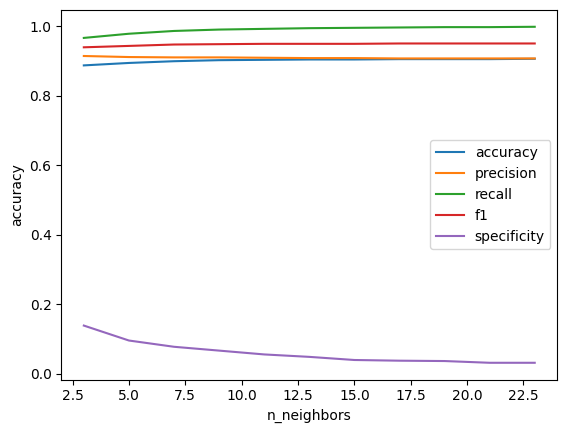

In [158]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 25, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [159]:
# Choose KNN with n_neighbors = 11
row = knn_measures[knn_measures['n_neighbors'] == 11]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.901,0.909,0.990,0.948,0.060,"[[125, 1951], [194, 19468]]"
1,Random Forest,0.904,0.910,0.991,0.949,0.072,"[[150, 1926], [171, 19491]]"
2,KNN,0.903,0.909,0.992,0.949,0.056,"[[116, 1960], [154, 19508]]"


## Overall comparison of the models

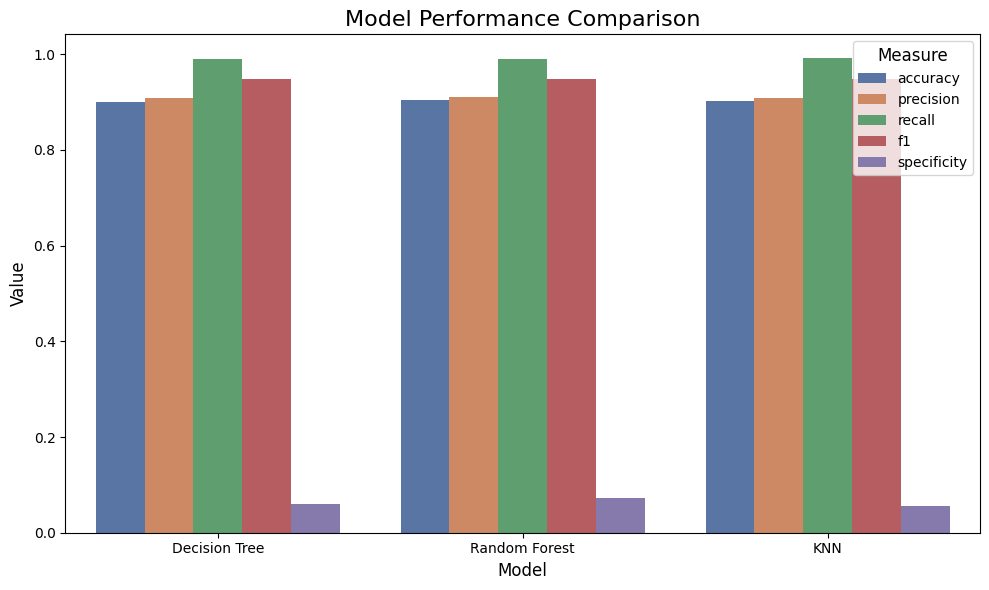

In [160]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

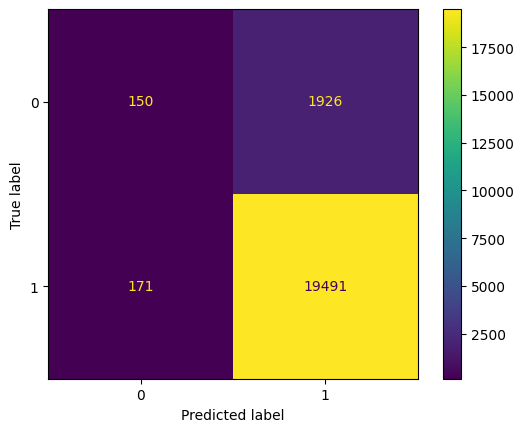

In [161]:
# plot confusion matrix of random forest
rf_cm = models[models['model'] == 'Random Forest']['cm'].values[0]
ConfusionMatrixDisplay(rf_cm).plot()

As we can see, these models seem to perform very well. All of them achieve accuracy, F1-score, recall and precision around 0.9.

Does this mean that we can move forward to more complex models? Not at all.
All these models are getting very low values for specificity and very few cases of True Negatives, meaning they are not good at capturing the negative class. This indicates the presence of very underfitted models, biased towards the positive class.

The confusion matrices resulting of each of these models prove that these models are not capable of correclty predicting a considerbale amount of negative cases.

In [162]:
# Frequency of target variable
print(y.value_counts())

# Frequency of target variable in percentage
print(y.value_counts(normalize=True))

health_ins
1.0    65553
0.0     6905
Name: count, dtype: int64
health_ins
1.0    0.904703
0.0    0.095297
Name: proportion, dtype: float64


Once we are using the trainig dataset to both train and validate our models, the "classical" metrics are not enough to reason about model performance. 

This dataset is highly imbalanced, meaning that both test and validation partitions (generated from itself) will have a similar distribution. So, if we use a model that learns to predict everything as positive, when tested in a dataset with similar distribution, it will achieve very good accuracy, F1, ... metrics.

In [163]:
# Frequency of target variable in train partition
print(y_train.value_counts(dropna=False, normalize=True))

# Frequency of target variable in test partition
print(y_test.value_counts(dropna=False, normalize=True))

health_ins
1.0    0.904791
0.0    0.095209
Name: proportion, dtype: float64
health_ins
1.0    0.904499
0.0    0.095501
Name: proportion, dtype: float64


Next section will focus on how to address this issue, by aplying balacing techniques to the dataset.

# Dealing with imbalanced data

In this section, we will apply some SMOTE techniques to the training data in order to solve the highly imbalanced data problem.

We will try several SMOTE techniques to generate some datasets. Then, these datasets will be compared according to their data-quality metrics (using `problexity` library)

The SMOTE techniques that we will use are:
- **Borderline SMOTE** (over-sampling the minority class reinforcing the border between the classes)
- **ADASYN** (Adaptive Synthetic Sampling: focuses on generating samples of minotiy class that are harder to classify)
- **SMOTE-TL** (SMOTE Tomek Links: combines over-sampling of the minority class with under-sampling of the majority class by removing Tomek links)
- **SMOTE-ENN** (SMOTE Edited Nearest Neighbors: combines over-sampling of the minority class with under-sampling of the majority class by cleaning the majority class with ENN)
- **SVM-SMOTE** (SMOTE Support Vector Machine: uses SVM to generate synthetic samples)

In [164]:
def print_target_dist(y, dataset_name):
    print(f"Frequency in {dataset_name} dataset: {y.value_counts()}")
    print(f"Percentage in {dataset_name} dataset: {y.value_counts(normalize=True).round(3)}")

In [165]:
# Number of cases and percentage of each class in the original dataset
print_target_dist(y, 'original')

Frequency in original dataset: health_ins
1.0    65553
0.0     6905
Name: count, dtype: int64
Percentage in original dataset: health_ins
1.0    0.905
0.0    0.095
Name: proportion, dtype: float64


## SMOTE Edited Nearest Neighbors (SMOTE-ENN)

In [166]:
X_smoteenn, y_smoteenn = SMOTEENN(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_smoteenn, 'SMOTE-ENN')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-ENN dataset: health_ins
0.0    62096
1.0    47810
Name: count, dtype: int64
Percentage in SMOTE-ENN dataset: health_ins
0.0    0.565
1.0    0.435
Name: proportion, dtype: float64


## SMOTE Tomek Links (SMOTE-TL)

In [167]:
X_smotetl, y_smotetl = SMOTETomek(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_smotetl, 'SMOTE-TomekLinks')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-TomekLinks dataset: health_ins
1.0    65231
0.0    65231
Name: count, dtype: int64
Percentage in SMOTE-TomekLinks dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE

In [168]:
X_borderline, y_borderline = BorderlineSMOTE(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_borderline, 'BorderlineSMOTE')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in BorderlineSMOTE dataset: health_ins
1.0    65553
0.0    65553
Name: count, dtype: int64
Percentage in BorderlineSMOTE dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE over SMOTE-ENN

In [169]:
X_enn_borderline, y_enn_borderline = BorderlineSMOTE(random_state=42,n_jobs=-1).fit_resample(X_smoteenn, y_smoteenn)
print_target_dist(y_enn_borderline, 'SMOTE-ENN + BorderlineSMOTE')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-ENN + BorderlineSMOTE dataset: health_ins
0.0    62096
1.0    62096
Name: count, dtype: int64
Percentage in SMOTE-ENN + BorderlineSMOTE dataset: health_ins
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## ADASYN

In [170]:
X_adasyn, y_adasyn = ADASYN(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_adasyn, 'ADASYN')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in ADASYN dataset: health_ins
0.0    66364
1.0    65553
Name: count, dtype: int64
Percentage in ADASYN dataset: health_ins
0.0    0.503
1.0    0.497
Name: proportion, dtype: float64


## SVM-SMOTE

In [171]:
X_svm_smote, y_svm_smote = SVMSMOTE(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_svm_smote, 'SVM-SMOTE')

/home/davisp/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SVM-SMOTE dataset: health_ins
1.0    65553
0.0    65553
Name: count, dtype: int64
Percentage in SVM-SMOTE dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Comparison of the datasets

In [172]:
datasets = {
    'smote-enn': (X_smoteenn, y_smoteenn),
    'borderline': (X_borderline, y_borderline),
    'smote-tl': (X_smotetl, y_smotetl),
    'enn-borderline': (X_enn_borderline, y_enn_borderline),
    'adasyn-smote': (X_adasyn, y_adasyn),
    'svm-smote': (X_svm_smote, y_svm_smote)
}

fb_measures = pd.DataFrame([], columns=['dataset', 'f1', 'f2', 'f3', 'f4'])

for dataset, (X, y) in datasets.items():
    print(f'Calculating metrics for {dataset}')
    f1 = round(pbx.f1(X, y),3)
    f2 = round(pbx.f2(X, y),3)
    f3 = round(pbx.f3(X, y),3)
    f4 = round(pbx.f4(X, y),3)
    fb_measures.loc[len(fb_measures)] = [dataset, f1, f2, f3, f4]

fb_measures

Calculating metrics for smote-enn
Calculating metrics for borderline
Calculating metrics for smote-tl
Calculating metrics for enn-borderline
Calculating metrics for adasyn-smote
Calculating metrics for svm-smote


,dataset,f1,f2,f3,f4
0,smote-enn,0.690,0.514,0.997,0.996
1,borderline,0.760,0.514,0.997,0.996
2,smote-tl,0.787,0.514,0.997,0.996
3,enn-borderline,0.744,0.514,0.997,0.996
4,adasyn-smote,0.818,0.514,0.997,0.996
5,svm-smote,0.610,0.000,0.969,0.915


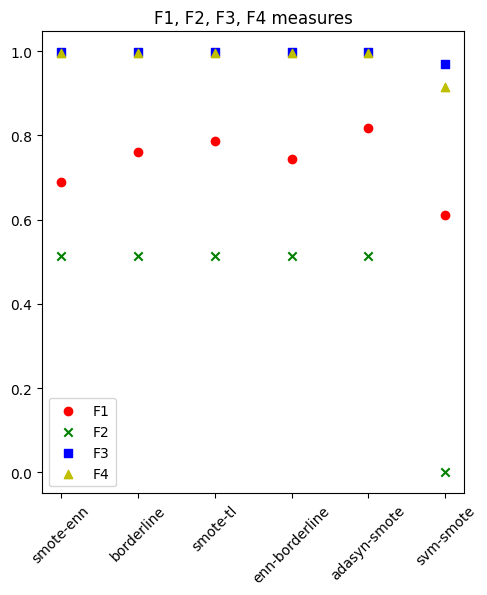

In [173]:
# Plot feature based measures
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fb_measures['dataset'], fb_measures['f1'], color='r', label='F1', marker='o')
plt.scatter(fb_measures['dataset'], fb_measures['f2'], color='g', label='F2', marker='x')
plt.scatter(fb_measures['dataset'], fb_measures['f3'], color='b', label='F3', marker='s')
plt.scatter(fb_measures['dataset'], fb_measures['f4'], color='y', label='F4', marker='^')
plt.xticks(rotation=45)
plt.legend()
plt.title('F1, F2, F3, F4 measures')
plt.show()

Remembering the meaning of each measure:
- **F1**: class separability
- **F2**: feature overlap
- **F3**: best single feature
- **F4**: combined feature effectiveness

The objective is to find a good trade-off between high F1 and low F2.

In [174]:
# Choose SVM-SMOTE as the best resampling method
df = pd.concat([X_svm_smote, y_svm_smote], axis=1)
df.shape

(131106, 20)

# Model Selection

Now that we have treated the imbalance issue in the training data, we can proceed to a more extensive exploration of classification algorithms. The objective of this section is to identify the best model for the problem, in order to use it for the final predictions.

The following algorithms will be tested:
- Decision Tree
- Random Forest
- K-Nearest Neighbors
- Support Vector Machine
- Logistic Regression
- Neural Network (Multi-Layer Perceptron)
- Bayesian Classifier

For evaluating these models, we will consider several performance metrics: accuracy, precision, recall, F1 score, specificity. We will also look at the confusion matrix of each model. Moreover, we will divide the full training set into training and test partitions, in order to perform hyperparameter tuning and to evaluate performance.

In [175]:
# Splitting the columns into features and target
X = df.drop(['health_ins'], axis=1)
y = df['health_ins']

X.shape

(131106, 19)

In [176]:
# Divide the data into training and test partitions (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [177]:
# Dataframe to store the results of the models
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

## Decision Trees

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with None
None generates the following depth: 40


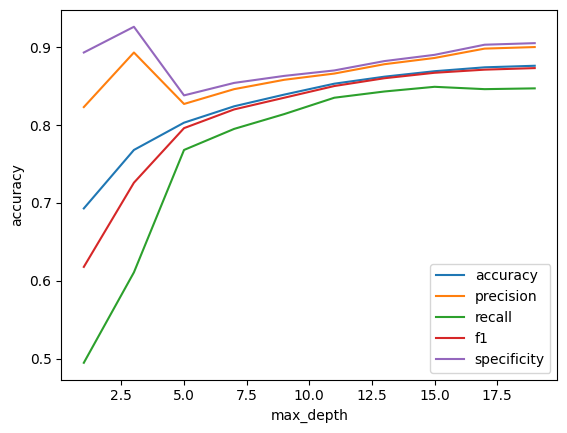

In [178]:
dt_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 20, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dt_measures.loc[len(dt_measures)] = new_row

    if max_depth == None:
        print(f'None generates the following depth: {model.get_depth()}')


plot_measures(dt_measures)

In [179]:
# Choose decision tree with max_depth = 15
row = dt_measures[dt_measures['max_depth'] == 15]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.89,"[[17419, 2156], [2990, 16767]]"


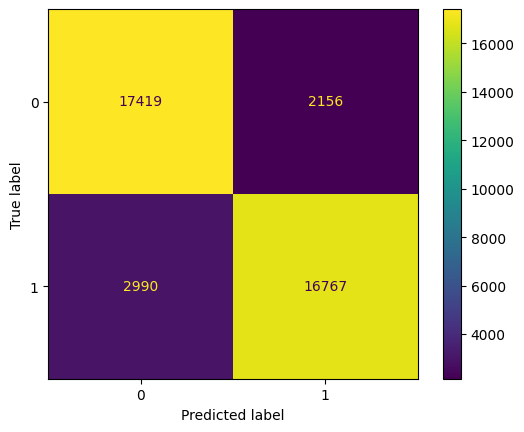

In [180]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


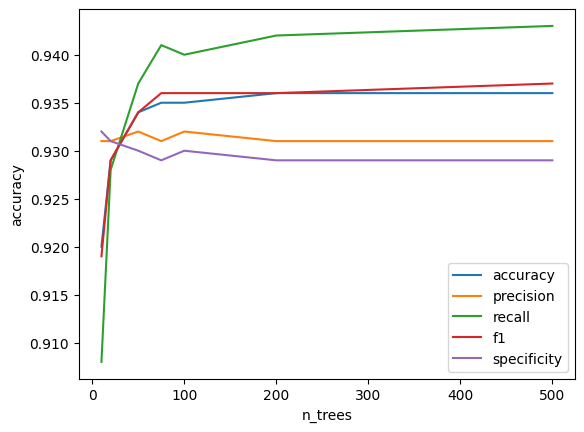

In [181]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [182]:
# Choose random forest with n_trees = 100
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.89,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.93,"[[18212, 1363], [1176, 18581]]"


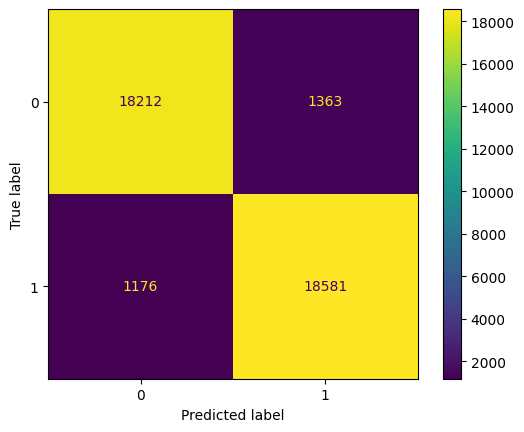

In [183]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## K Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23


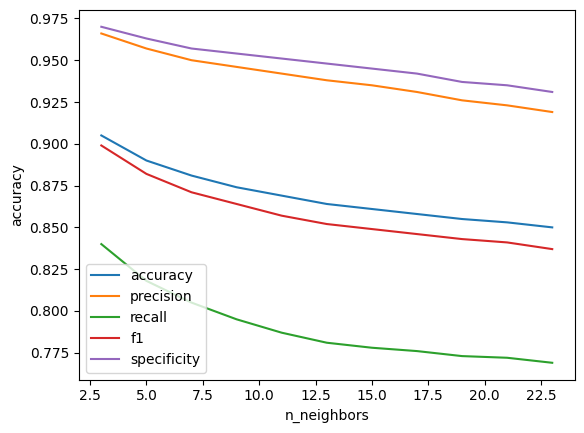

In [184]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 25, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [185]:
# Choose KNN with n_neighbors = 5
row = knn_measures[knn_measures['n_neighbors'] == 5]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"


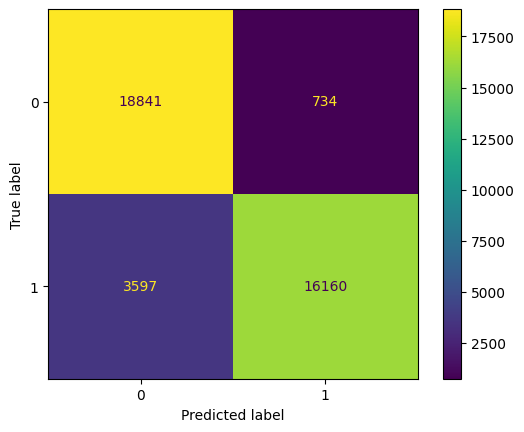

In [186]:
ConfusionMatrixDisplay(row.iloc[0,6]).plot()

## Logistic Regression

In [187]:
parameters = {
    'C': [0.01, 0.1, 1, 10, 50],
    'solver': ['sag', 'saga', 'lbfgs'],
    'max_iter': [500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.795 total time=   0.6s
[CV 3/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.794 total time=   0.6s
[CV 4/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.800 total time=   0.6s
[CV 5/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.801 total time=   0.6s
[CV 2/5] END ..C=0.01, max_iter=500, solver=sag;, score=0.790 total time=   0.6s
[CV 1/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.795 total time=   0.6s
[CV 2/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.789 total time=   0.6s
[CV 3/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.794 total time=   0.5s
[CV 1/5] END .C=0.01, max_iter=1000, solver=sag;, score=0.795 total time=   0.6s
[CV 5/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.801 total time=   0.6s
[CV 4/5] END C=0.01, max_iter=500, solver=lbfgs;, score=0.800 total time=   0.6s
[CV 2/5] END .C=0.01, max_iter=1000, solver=sag

/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .....C=1, max_iter=500, solver=sag;, score=0.791 total time=  13.6s
[CV 4/5] END .....C=1, max_iter=500, solver=sag;, score=0.803 total time=  13.3s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .....C=1, max_iter=500, solver=sag;, score=0.797 total time=  16.3s
[CV 3/5] END .....C=1, max_iter=500, solver=sag;, score=0.797 total time=  15.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=1, max_iter=500, solver=saga;, score=0.798 total time=  17.1s
[CV 2/5] END ....C=1, max_iter=500, solver=saga;, score=0.790 total time=  17.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=1, max_iter=500, solver=saga;, score=0.803 total time=  16.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=1, max_iter=500, solver=saga;, score=0.797 total time=  17.3s
[CV 5/5] END .....C=1, max_iter=500, solver=sag;, score=0.803 total time=  19.2s
[CV 1/5] END ..C=1, max_iter=1000, solver=lbfgs;, score=0.797 total time=   1.1s
[CV 2/5] END ..C=1, max_iter=1000, solver=lbfgs;, score=0.791 total time=   0.5s
[CV 3/5] END ..C=1, max_iter=1000, solver=lbfgs;, score=0.796 total time=   0.6s
[CV 4/5] END ..C=1, max_iter=1000, solver=lbfgs;, score=0.803 total time=   1.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=1, max_iter=500, solver=saga;, score=0.803 total time=  18.5s
[CV 5/5] END ..C=1, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.7s
[CV 1/5] END ....C=1, max_iter=1000, solver=sag;, score=0.797 total time=  19.0s
[CV 2/5] END ....C=1, max_iter=1000, solver=sag;, score=0.791 total time=  19.6s
[CV 3/5] END ....C=1, max_iter=1000, solver=sag;, score=0.796 total time=  18.3s
[CV 4/5] END ....C=1, max_iter=1000, solver=sag;, score=0.803 total time=  18.6s
[CV 5/5] END ....C=1, max_iter=1000, solver=sag;, score=0.803 total time=  19.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=10, max_iter=500, solver=sag;, score=0.798 total time=  15.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=10, max_iter=500, solver=sag;, score=0.791 total time=  16.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=10, max_iter=500, solver=sag;, score=0.796 total time=  15.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=10, max_iter=500, solver=sag;, score=0.803 total time=  13.9s
[CV 1/5] END ..C=10, max_iter=500, solver=lbfgs;, score=0.798 total time=   0.7s
[CV 2/5] END ..C=10, max_iter=500, solver=lbfgs;, score=0.790 total time=   0.6s
[CV 3/5] END ..C=10, max_iter=500, solver=lbfgs;, score=0.796 total time=   0.6s
[CV 4/5] END ..C=10, max_iter=500, solver=lbfgs;, score=0.803 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=10, max_iter=500, solver=sag;, score=0.803 total time=  13.6s
[CV 5/5] END ..C=10, max_iter=500, solver=lbfgs;, score=0.803 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=10, max_iter=500, solver=saga;, score=0.798 total time=  16.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=10, max_iter=500, solver=saga;, score=0.791 total time=  16.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=1, max_iter=1000, solver=saga;, score=0.803 total time=  33.8s
[CV 3/5] END ...C=1, max_iter=1000, solver=saga;, score=0.797 total time=  34.7s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=1, max_iter=1000, solver=saga;, score=0.797 total time=  37.0s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=1, max_iter=1000, solver=saga;, score=0.803 total time=  34.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=1, max_iter=1000, solver=saga;, score=0.791 total time=  36.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=10, max_iter=500, solver=saga;, score=0.796 total time=  17.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=10, max_iter=500, solver=saga;, score=0.803 total time=  18.8s
[CV 1/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.798 total time=   0.7s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=10, max_iter=500, solver=saga;, score=0.803 total time=  18.0s
[CV 2/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.790 total time=   0.6s
[CV 3/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.796 total time=   0.7s
[CV 4/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.7s
[CV 5/5] END .C=10, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.7s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=10, max_iter=1000, solver=sag;, score=0.798 total time=  27.3s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=10, max_iter=1000, solver=sag;, score=0.791 total time=  29.4s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=10, max_iter=1000, solver=sag;, score=0.796 total time=  27.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=50, max_iter=500, solver=sag;, score=0.791 total time=  14.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=50, max_iter=500, solver=sag;, score=0.798 total time=  15.2s
[CV 1/5] END ...C=50, max_iter=500, solver=saga;, score=0.798 total time=   1.0s
[CV 2/5] END ...C=50, max_iter=500, solver=saga;, score=0.791 total time=   1.0s
[CV 3/5] END ...C=50, max_iter=500, solver=saga;, score=0.796 total time=   1.1s
[CV 4/5] END ...C=50, max_iter=500, solver=saga;, score=0.803 total time=   1.1s
[CV 4/5] END ...C=10, max_iter=1000, solver=sag;, score=0.803 total time=  27.4s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=50, max_iter=500, solver=saga;, score=0.803 total time=   1.1s
[CV 2/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.791 total time=   0.6s
[CV 5/5] END ...C=10, max_iter=1000, solver=sag;, score=0.803 total time=  27.5s
[CV 1/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.798 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.796 total time=   0.7s
[CV 4/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.803 total time=   0.7s
[CV 5/5] END ..C=50, max_iter=500, solver=lbfgs;, score=0.803 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..C=10, max_iter=1000, solver=saga;, score=0.798 total time=  33.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=50, max_iter=500, solver=sag;, score=0.796 total time=  15.5s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=10, max_iter=1000, solver=saga;, score=0.796 total time=  34.8s
[CV 1/5] END ..C=50, max_iter=1000, solver=saga;, score=0.798 total time=   1.0s
[CV 2/5] END ..C=50, max_iter=1000, solver=saga;, score=0.791 total time=   1.7s
[CV 3/5] END ..C=50, max_iter=1000, solver=saga;, score=0.796 total time=   1.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..C=10, max_iter=1000, solver=saga;, score=0.803 total time=  36.8s
[CV 4/5] END ..C=50, max_iter=1000, solver=saga;, score=0.803 total time=   1.2s
[CV 5/5] END ..C=50, max_iter=1000, solver=saga;, score=0.803 total time=   1.1s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=50, max_iter=500, solver=sag;, score=0.803 total time=  15.7s
[CV 1/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.798 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..C=10, max_iter=1000, solver=saga;, score=0.791 total time=  38.9s
[CV 2/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.791 total time=   0.6s
[CV 3/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.796 total time=   0.7s
[CV 4/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.7s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=50, max_iter=500, solver=sag;, score=0.803 total time=  17.2s
[CV 5/5] END .C=50, max_iter=1000, solver=lbfgs;, score=0.803 total time=   0.8s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=10, max_iter=1000, solver=saga;, score=0.803 total time=  38.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=50, max_iter=1000, solver=sag;, score=0.803 total time=  26.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=50, max_iter=1000, solver=sag;, score=0.796 total time=  26.6s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=50, max_iter=1000, solver=sag;, score=0.798 total time=  28.3s
[CV 2/5] END ...C=50, max_iter=1000, solver=sag;, score=0.791 total time=  28.2s


/home/davisp/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=50, max_iter=1000, solver=sag;, score=0.803 total time=  25.1s


{'C': 50, 'max_iter': 500, 'solver': 'lbfgs'}

In [188]:
lr = LogisticRegression(**best_params)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.801,
 'precision': np.float64(0.806),
 'recall': np.float64(0.795),
 'f1': np.float64(0.8),
 'specificity': np.float64(0.806),
 'cm': array([[15787,  3788],
        [ 4052, 15705]])}

In [189]:
models.loc[len(models)] = {'model': 'Logistic Regression', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"
3,Logistic Regression,0.801,0.806,0.795,0.800,0.806,"[[15787, 3788], [4052, 15705]]"


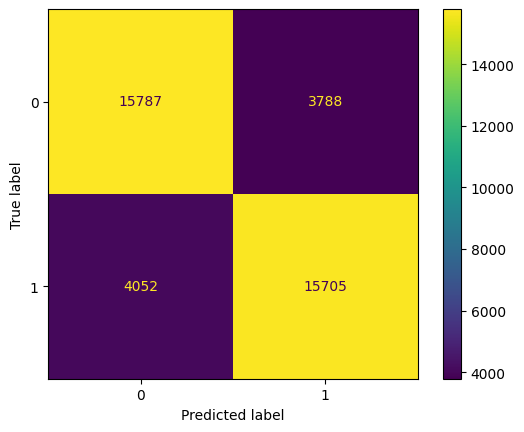

In [190]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Support Vector Machine

In [191]:
parameters = {
    'kernel': ['rbf'],
    'random_state': [42],
}

grid_search = GridSearchCV(SVC(), parameters, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'kernel': 'rbf', 'random_state': 42}

In [192]:
svm = SVC(**best_params)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.817,
 'precision': np.float64(0.84),
 'recall': np.float64(0.785),
 'f1': np.float64(0.811),
 'specificity': np.float64(0.849),
 'cm': array([[16620,  2955],
        [ 4254, 15503]])}

In [193]:
models.loc[len(models)] = {'model': 'SVM', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"
3,Logistic Regression,0.801,0.806,0.795,0.800,0.806,"[[15787, 3788], [4052, 15705]]"
4,SVM,0.817,0.840,0.785,0.811,0.849,"[[16620, 2955], [4254, 15503]]"


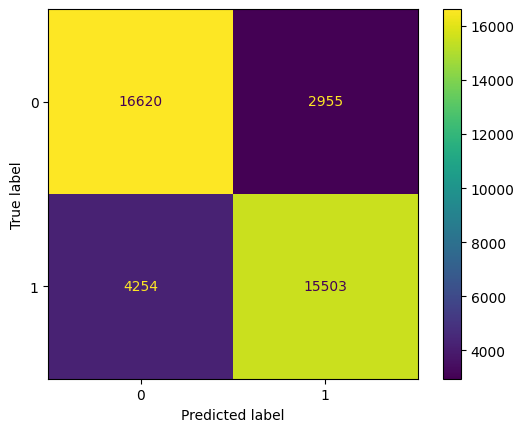

In [194]:
ConfusionMatrixDisplay(measures['cm']).plot()

## XGBOOST

In [195]:
parameters = {
    'objective':['binary:logistic'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
grid_search = GridSearchCV(xgb.XGBClassifier(), parameters, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 7,
 'objective': 'binary:logistic',
 'subsample': 0.5}

In [196]:
xgb = xgb.XGBClassifier(**best_params, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.914,
 'precision': np.float64(0.906),
 'recall': np.float64(0.924),
 'f1': np.float64(0.915),
 'specificity': np.float64(0.903),
 'cm': array([[17683,  1892],
        [ 1499, 18258]])}

In [197]:
models.loc[len(models)] = {'model': 'xgb', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"
3,Logistic Regression,0.801,0.806,0.795,0.800,0.806,"[[15787, 3788], [4052, 15705]]"
4,SVM,0.817,0.840,0.785,0.811,0.849,"[[16620, 2955], [4254, 15503]]"
5,xgb,0.914,0.906,0.924,0.915,0.903,"[[17683, 1892], [1499, 18258]]"


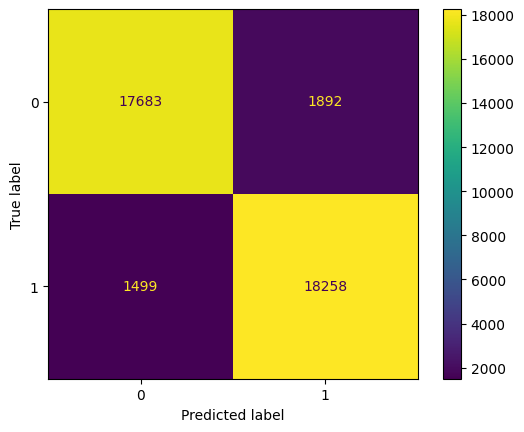

In [198]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Multi-Layer Perceptron (Neural Network)

In [199]:
parameters = {
    'hidden_layer_sizes': [(10,), (12, 6), (13,9,5)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'max_iter': [500, 1000],
    'random_state': [42],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(MLPClassifier(), parameters, cv=5, scoring='f1', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.816 total time=   6.4s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.797 total time=  10.1s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500, random_state=42, solver=adam;, score=0.814 total time=   4.3s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=1000, random_state=42, solver=adam;, score=0.809 total time=  11.0s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=500, random_state=42, solver=adam;, score=0.809 total time=  11.1s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=500, random_state=42, solver=adam;,

{'activation': 'relu',
 'hidden_layer_sizes': (13, 9, 5),
 'learning_rate_init': 0.001,
 'max_iter': 500,
 'random_state': 42,
 'solver': 'adam'}

In [200]:
mlp = MLPClassifier(**best_params)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.827,
 'precision': np.float64(0.842),
 'recall': np.float64(0.807),
 'f1': np.float64(0.824),
 'specificity': np.float64(0.847),
 'cm': array([[16588,  2987],
        [ 3811, 15946]])}

In [201]:
models.loc[len(models)] = {'model': 'MLP', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"
3,Logistic Regression,0.801,0.806,0.795,0.800,0.806,"[[15787, 3788], [4052, 15705]]"
4,SVM,0.817,0.840,0.785,0.811,0.849,"[[16620, 2955], [4254, 15503]]"
5,xgb,0.914,0.906,0.924,0.915,0.903,"[[17683, 1892], [1499, 18258]]"
6,MLP,0.827,0.842,0.807,0.824,0.847,"[[16588, 2987], [3811, 15946]]"


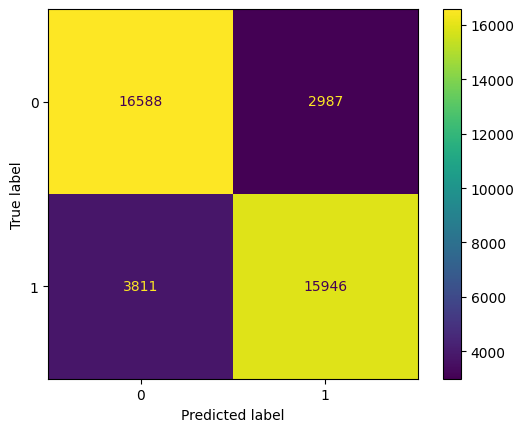

In [202]:
ConfusionMatrixDisplay(measures['cm']).plot()

## Bayesian Classifier

In [203]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
measures = get_metrics(y_pred)
measures

{'accuracy': 0.767,
 'precision': np.float64(0.773),
 'recall': np.float64(0.757),
 'f1': np.float64(0.765),
 'specificity': np.float64(0.776),
 'cm': array([[15194,  4381],
        [ 4800, 14957]])}

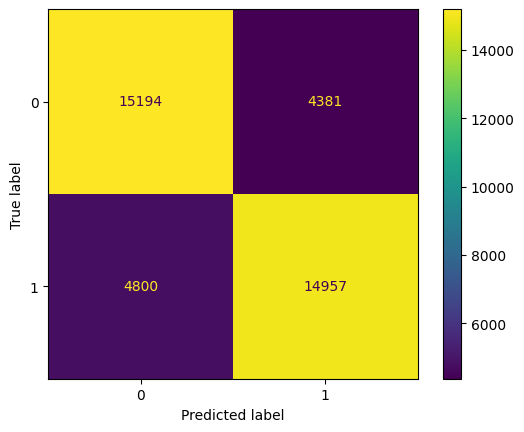

In [204]:
ConfusionMatrixDisplay(measures['cm']).plot()

In [205]:
models.loc[len(models)] = {'model': 'Naive Bayes', **measures}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.869,0.886,0.849,0.867,0.890,"[[17419, 2156], [2990, 16767]]"
1,Random Forest,0.935,0.932,0.940,0.936,0.930,"[[18212, 1363], [1176, 18581]]"
2,KNN,0.890,0.957,0.818,0.882,0.963,"[[18841, 734], [3597, 16160]]"
3,Logistic Regression,0.801,0.806,0.795,0.800,0.806,"[[15787, 3788], [4052, 15705]]"
4,SVM,0.817,0.840,0.785,0.811,0.849,"[[16620, 2955], [4254, 15503]]"
5,xgb,0.914,0.906,0.924,0.915,0.903,"[[17683, 1892], [1499, 18258]]"
6,MLP,0.827,0.842,0.807,0.824,0.847,"[[16588, 2987], [3811, 15946]]"
7,Naive Bayes,0.767,0.773,0.757,0.765,0.776,"[[15194, 4381], [4800, 14957]]"


## Overall comparison of the models

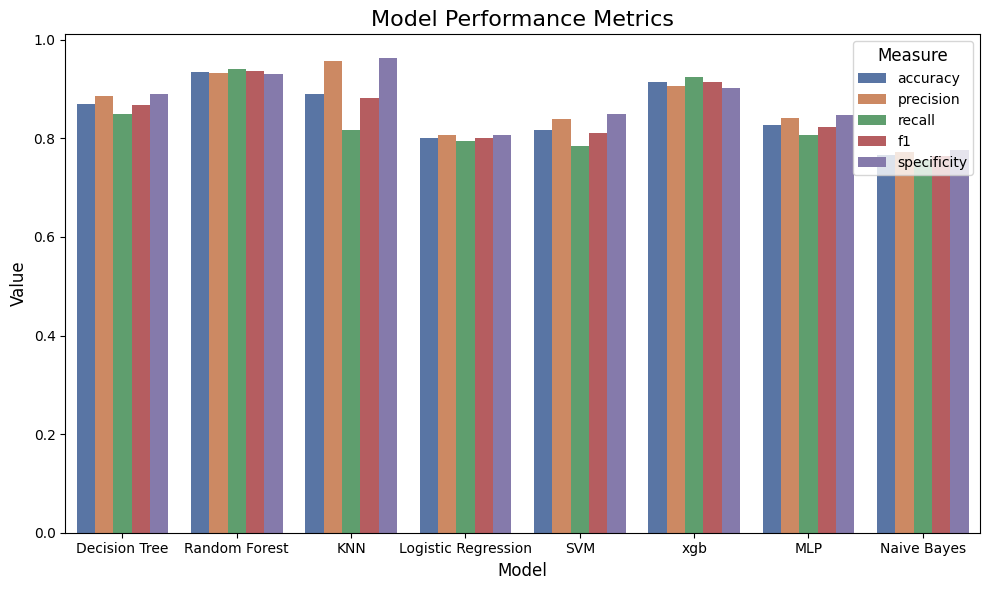

In [206]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")

plt.title("Model Performance Metrics", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

After this analysis, we chose the Random Forest (100 trees) as the best model to make the final predictions.

# Prediction

In this section, we apply the training dataset to the best model we have found (Random Forest - 100 trees) and make predictions on the test dataset `customer_test_masked.csv`.

In [207]:
X_train = df.drop('health_ins', axis=1)
y_train = df['health_ins']

In [208]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [209]:
df_to_predict = pd.read_csv('../data/customer_test_masked.csv')
ids = df_to_predict['custid']
df_to_predict = preprocess(df_to_predict, isTest=True)
df_to_predict.head()

,sex,income,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_0,is_employed_1,is_employed_2
0,1.0,10.2717,1.0,8.243,0.062500,3.0445,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,10.5967,1.0,2.568,0.625000,3.7136,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,12.2210,3.0,4.459,0.104167,4.3944,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.6931,1.0,5.811,0.083333,3.4340,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,10.5967,4.0,1.892,0.604167,5.0173,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [210]:
X.columns

Index(['sex', 'income', 'num_vehicles', 'age', 'state_of_res', 'gas_usage',
       'rooms', 'recent_move_b', 'marital_status_Divorced/Separated',
       'marital_status_Married', 'marital_status_Never married',
       'marital_status_Widowed', 'housing_type_Homeowner free and clear',
       'housing_type_Homeowner with mortgage/loan',
       'housing_type_Occupied with no rent', 'housing_type_Rented',
       'is_employed_0', 'is_employed_1', 'is_employed_2'],
      dtype='object')

In [211]:
df_to_predict.columns

Index(['sex', 'income', 'num_vehicles', 'age', 'state_of_res', 'gas_usage',
       'rooms', 'recent_move_b', 'marital_status_Divorced/Separated',
       'marital_status_Married', 'marital_status_Never married',
       'marital_status_Widowed', 'housing_type_Homeowner free and clear',
       'housing_type_Homeowner with mortgage/loan',
       'housing_type_Occupied with no rent', 'housing_type_Rented',
       'is_employed_0', 'is_employed_1', 'is_employed_2'],
      dtype='object')

In [212]:
# difference between set of columns in X and df_to_predict
set(X.columns) - set(df_to_predict.columns)

set()

In [213]:
predictions = model.predict(df_to_predict)
predictions = ['TRUE' if p == 1 else 'FALSE' for p in predictions]
output = pd.DataFrame({'custid': ids, 'health_ins': predictions})
output

,custid,health_ins
0,001115999_01,TRUE
1,000566299_01,FALSE
2,001397329_01,TRUE
3,000843100_01,TRUE
4,000260071_03,TRUE
...,...,...
799,000961606_04,FALSE
800,001063357_01,TRUE
801,000613999_02,TRUE
802,000087463_03,TRUE


In [214]:
pd.DataFrame(output).to_csv('../data/predictions.csv', index=False)

Our predictions are saved in a file named `predictions.csv` and this file is ready to be submitted to the competition.

# Conclusion

- **Data Quality is essential**, no model can perform well if the data is not properly preprocessed and treated.

- When dealing with **imbalanced data**, relying solely on metrics like accuracy or F1 score can lead to misleading and **unrealistic conclusions**.

- **Analyzing confusion matrices** and more granular metrics such as specificity is crucial for a deeper evaluation of model performance.

- **Exploring** processes to **generate synthetic** data and **advanced imputation techniques** is highly valuable.

- A **well-trained** and **efficient algorithm** (e.g. Random Forest) sometimes can achieve **higher performance** than more **complex models** (e.g., SVMs and XGBoost).

